In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, timedelta


from sklearn.model_selection import train_test_split
import glob
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

from tqdm.notebook import tqdm
from pycaret.regression import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [5]:
#파이썬
import sys
print(sys.version)

#탠서플로
import tensorflow as tf
tf.__version__

#캐라스

import keras
keras.__version__

3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]


Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow'

# Pycaret을 이용한 튜닝 및 예측
 - 3 표준편차 기준 이상치 대체 반응변수
 - 왜도 3 이상 값들 로그변환 설명변수
 - VIF < 11 인 값들
 - 부스팅 / 배깅 / 블랜딩 3개 혼합모델

#### 0. 데이터 불러오기
- stepwise로 선택된 변수
- 이상치가 대체된 배출량 data

In [35]:
data = pd.read_csv("행정동1 군집4번의 data 이상치 3.csv")
variable_dummy = np.load("행정동1 label 4 VIF10 선택변수.npy")
print(len(variable_dummy))
data.shape

15


(3831, 323)

성능평가 방법
- RMSLE

In [36]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

def rmsle(y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def eval_reg(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    mae_val = mean_absolute_error(y,pred)
    print("RMSLE : {0:.3f}, RMSE : {1:.3f}, MAE : {2:,.3f}".format(rmsle_val,rmse_val,mae_val))
    return rmsle_val,rmse_val,mae_val

#### 1. 데이터 생성하기
- 로그변환

In [102]:
Y = data["배출량"]
    
dummy = pd.get_dummies(data[["년","월","일","요일","분기"]],columns = ["년","월","일","요일","분기"]).columns
variable_nodummy = list(set(variable_dummy).difference(dummy))
# stepwise로 선택된 변수 중 dummy가 아닌 것들
    
select_dummy = list(set(variable_dummy).difference(variable_nodummy))
# stepwsie로 선택된 변수 중 dummy인 변수들
    
X_1 = pd.get_dummies(data.drop(["일자","행정시","배출량","행정동명"],axis=1)
                         ,columns=["년","월","일","요일","분기"])[variable_nodummy]
# X_1 : 더미변수를 제하고 stepwise로 선택된 모든 변수 dataframe

X_2 = pd.get_dummies(data.drop(["일자","행정시","배출량","행정동명"],axis=1)
                         ,columns=["년","월","일","요일","분기"])[select_dummy]
# X_2 : stepwise로 선택된 모든 더미변수 dataframe

loglist=[]
# 왜도 3인 설명변수 log1p 변환
for val in list(X_1.columns):
    if abs(X_1[val].skew())>3:
        X_1[val] = np.log1p(X_1[val])
        loglist.append(val)
        
X_1 = pd.DataFrame(X_1)
    
X_3 = data["행정동명"]
# Categorical Features인 행정동명
    
X = pd.concat([X_1,X_2,X_3],axis=1)
# X1, X2, X3 데이터 concat

x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.2, shuffle=True, random_state=0)
train = pd.concat([x_train, y_train], axis = 1)

reg = setup(data=train,
                target='배출량',
                numeric_imputation = 'mean',
                normalize = True,
                normalize_method = 'zscore',
                categorical_features = ["행정동명"],
                silent= True,
                fold_strategy = 'timeseries',
                fold = 3,
                session_id = 0,
                verbose=False)
print(loglist)

['확진자수', '일강수량', '연휴다음날']


단일 모델 선택하기 위한 성능 비교

In [51]:
best_5_d = compare_models(sort = 'RMSLE', n_select = 5)
print(best_5_d)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,196837.7594,84955313160.3515,289292.8487,0.9399,0.2110,0.1563,0.9533
rf,Random Forest Regressor,213695.3892,103524823508.7888,320294.2887,0.9265,0.2426,0.1779,2.0933
lightgbm,Light Gradient Boosting Machine,211338.3905,94393875588.0352,304638.6792,0.9331,0.2582,0.1856,2.1733
dt,Decision Tree Regressor,281413.6709,197013390177.0084,442835.5580,0.8598,0.2958,0.2035,0.1100
gbr,Gradient Boosting Regressor,268295.9144,133588337953.7056,364364.2719,0.9052,0.3879,0.2823,0.4633
knn,K Neighbors Regressor,341296.6875,235902140416.0000,482920.1979,0.8324,0.4370,0.3911,0.0667
ada,AdaBoost Regressor,469591.3646,305929769542.6961,552921.4652,0.7821,0.6334,0.7281,0.5000
huber,Huber Regressor,584136.5629,492743482694.8517,701722.9765,0.6491,0.7454,0.8115,0.0600
llar,Lasso Least Angle Regression,566854.4273,477108173940.1133,690406.0466,0.6603,0.7492,0.7379,0.0300
ridge,Ridge Regression,567014.1250,476817894058.6667,690201.5000,0.6605,0.7536,0.7399,10.0933


[ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=0, verbose=0, warm_start=False), RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False), LGBMRegressor(boosting_typ

#### (2)  모델 생성 및 튜닝 (단일 모델 3개 / 배깅 모델 3개 / 부스팅 3개 / 블렌딩 3개)
- RMSLE을 기준으로 상위 모델 선정 
- 단 다른 5개의 성능 지표 비교해서 결정

In [52]:
tuned_models = []

In [53]:
### 상위 모델 1번 : Extra Tree Regressor
model_01 = create_model("et")

model_01 = tune_model(model_01, fold= 3, n_iter = 100, optimize = 'RMSLE', verbose = True, choose_better = True)
tuned_models.append(model_01)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,274392.4411,154184503413.0974,392663.3462,0.8942,0.2892,0.2358
1,211584.8761,89620253334.3154,299366.4199,0.9331,0.2429,0.1838
2,207818.2696,95656954150.2976,309284.5844,0.9324,0.2152,0.1514
Mean,231265.1956,113153903632.5702,333771.4501,0.9199,0.2491,0.1903
SD,30534.3120,29117497923.0448,41839.2484,0.0182,0.0305,0.0347


In [54]:
### 상위 모델 2번 : Random Forest Regressor
model_02 = create_model("gbr")

model_02 = tune_model(model_02, fold= 3, n_iter = 100, optimize = 'RMSLE', verbose = True, choose_better = True)
tuned_models.append(model_02)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,230210.4143,110300783212.8867,332115.6172,0.9243,0.2687,0.2135
1,186592.4313,69691063184.6408,263990.6498,0.9480,0.2267,0.1688
2,180227.6239,72312063897.2004,268909.0253,0.9489,0.1853,0.1333
Mean,199010.1565,84101303431.5759,288338.4308,0.9404,0.2269,0.1719
SD,22214.4061,18556705289.3250,31020.1993,0.0114,0.0341,0.0328


In [55]:
#  Light Gradient Boosting Machine 튜닝 (상위 모델 3번)
model_03 = create_model('lightgbm')

model_03 = tune_model(model_03, fold= 3, n_iter = 100, optimize = 'RMSLE', verbose = True, choose_better = True)
tuned_models.append(model_03)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,254524.0480,156035526543.3934,395013.3245,0.8929,0.2651,0.1966
1,192609.8692,82029025625.2635,286407.0977,0.9387,0.2141,0.1562
2,192305.1871,79105665249.5457,281257.2937,0.9441,0.2050,0.1454
Mean,213146.3681,105723405806.0676,320892.5720,0.9253,0.2281,0.1661
SD,29258.7025,35596054358.0046,52453.4371,0.0230,0.0264,0.0220


배깅

In [56]:
prediction_models = []

bag_01_15 = ensemble_model(model_01 , n_estimators = 100, fold=3, optimize = 'RMSLE')
prediction_models.append(bag_01_15)

bag_02_15 = ensemble_model(model_02, n_estimators = 100, fold=3, optimize = 'RMSLE')
prediction_models.append(bag_02_15 )

bag_03_15 = ensemble_model(model_03, n_estimators = 100, fold=3, optimize = 'RMSLE')
prediction_models.append(bag_03_15)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,246917.6221,125099970222.4990,353694.7416,0.9142,0.2722,0.2169
1,191005.4880,77486528397.3616,278364.0214,0.9421,0.2340,0.1712
2,184368.9829,75174935247.8826,274180.4793,0.9469,0.1986,0.1394
Mean,207430.6977,92587144622.5811,302079.7474,0.9344,0.2349,0.1759
SD,28052.6136,23009400065.9178,36537.2524,0.0144,0.0300,0.0318


부스팅

In [57]:
boo_01 = ensemble_model(model_01, method = 'Boosting', fold=3, optimize='RMSLE')
prediction_models.append(boo_01)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,255681.3921,127720459468.2892,357379.9931,0.9124,0.2954,0.2449
1,189063.6354,70343879735.4190,265224.2065,0.9475,0.2370,0.1792
2,187471.1440,79186617761.0028,281401.1687,0.9440,0.1922,0.1414
Mean,210738.7238,92416985654.9036,301335.1228,0.9346,0.2416,0.1885
SD,31785.9149,25223004730.0287,40176.2296,0.0158,0.0422,0.0428


In [58]:
boo_02 = ensemble_model(model_02, method = 'Boosting', fold=3, optimize='RMSLE')
prediction_models.append(boo_02)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,247344.2296,119175556511.6156,345218.1289,0.9182,0.3119,0.2570
1,192818.6094,69668995148.6285,263948.8495,0.9480,0.2444,0.1905
2,188687.7214,77073836248.2723,277621.7503,0.9455,0.2042,0.1507
Mean,209616.8535,88639462636.1721,295596.2429,0.9372,0.2535,0.1994
SD,26730.5349,21802869685.8183,35529.1967,0.0135,0.0444,0.0439


In [59]:
boo_03 = ensemble_model(model_03, method = 'Boosting', fold=3, optimize='RMSLE')
prediction_models.append(boo_03)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,255862.6872,136570718844.9776,369554.7576,0.9063,0.3224,0.2589
1,194405.7449,80282400097.8706,283341.4903,0.9400,0.2394,0.1775
2,184593.5139,74917020658.0609,273709.7380,0.9471,0.1982,0.1411
Mean,211620.6487,97256713200.3030,308868.6619,0.9311,0.2533,0.1925
SD,31539.2713,27885361799.1640,43091.3318,0.0178,0.0517,0.0493


블렌딩

In [60]:
blend_3_soft = blend_models(estimator_list=[model_01, model_02, model_03], fold=3, optimize='RMSLE')
prediction_models.append(blend_3_soft)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,228506.8019,111430305893.1557,333811.7821,0.9235,0.2473,0.1937
1,176843.7290,65074244454.0530,255096.5395,0.9514,0.2069,0.1511
2,174698.9174,69969308262.2075,264517.1228,0.9506,0.1833,0.1296
Mean,193349.8161,82157952869.8054,284475.1481,0.9418,0.2125,0.1582
SD,24875.1588,20794925680.1463,35097.6204,0.0129,0.0264,0.0266


#### 생성된 모델에 대한 Train 데이터에 대한 성과 확인

In [61]:
for model in tuned_models:
    print(model.__class__.__name__)
    display(predict_model(model))

ExtraTreesRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,159604.0062,57821219304.1936,240460.4319,0.9592,0.1657,0.1187


,10만명당 발생률,지방세,확진자수,일강수량월편차,내국인_목적별 0 회의및업무,연_요일별배출건수비율,연_월부페결제금액비율,연_월결제금액_농축수산물,일강수량,단기4방문편차,장기1방문편차,월배출량비율,연_월결제건수비율,월_일별배출량비율,연휴다음날_0.6931471824645996,행정동명_대정읍,행정동명_성산읍,행정동명_애월읍,배출량,Label
0,-0.412924,-0.013259,-0.404899,-0.813383,-0.440712,-0.053862,0.258565,0.066286,-0.274438,1.533807,-0.271433,-0.126573,0.588243,-0.185334,0.0,0.0,0.0,1.0,267000.0,230153.50
1,-0.412924,0.900924,-0.404899,-0.704242,0.858970,1.453456,0.102695,0.596048,-0.508644,1.261902,-0.164588,-1.237949,-0.118683,0.573711,0.0,0.0,0.0,1.0,178750.0,228230.50
2,-0.412924,-1.310461,-0.404899,0.743368,1.866627,-0.456619,0.864239,-0.449590,-0.508644,0.383345,-0.043842,0.503596,0.866855,0.798357,0.0,0.0,1.0,0.0,1842100.0,1782630.00
3,-0.412924,0.538784,-0.404899,-0.699436,0.221659,-0.030031,-0.150512,-0.361341,-0.508644,-0.293844,0.442499,-0.796277,-1.651134,2.586190,0.0,1.0,0.0,0.0,2791500.0,2518103.50
4,-0.313934,0.968611,-0.404899,0.497265,-0.682478,-0.398990,-0.722825,0.083774,-0.508644,-0.825951,-0.788784,1.228344,1.314669,0.553786,0.0,1.0,0.0,0.0,3750250.0,3666032.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,-0.412924,0.709115,-0.404899,-0.031587,3.863791,-2.272844,-0.676921,-1.639147,-0.508644,1.572213,-0.594216,-0.491457,-0.177366,-0.524117,0.0,0.0,1.0,0.0,411300.0,420708.00
916,1.416610,-0.549434,2.224794,-0.568016,-1.419853,-0.414592,-1.074578,0.896658,0.064323,-0.808990,-0.703868,-1.718369,-0.893307,-1.261728,0.0,0.0,0.0,1.0,2084250.0,2206849.00
917,-0.412924,0.900924,-0.404899,-0.704242,0.858970,-1.641400,0.102695,0.596048,-0.508644,1.195178,-0.239229,-1.237949,-0.118683,-0.413106,0.0,0.0,0.0,1.0,160250.0,190562.00
918,-0.355775,-0.833305,-0.404899,1.099665,-0.196014,-0.376575,0.317724,-0.773375,-0.508644,-0.825620,-0.643835,0.498813,0.463315,-1.335576,0.0,0.0,1.0,0.0,1914800.0,1776507.50


GradientBoostingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,166547.2745,58582271648.5074,242037.7484,0.9587,0.1775,0.1305


,10만명당 발생률,지방세,확진자수,일강수량월편차,내국인_목적별 0 회의및업무,연_요일별배출건수비율,연_월부페결제금액비율,연_월결제금액_농축수산물,일강수량,단기4방문편차,장기1방문편차,월배출량비율,연_월결제건수비율,월_일별배출량비율,연휴다음날_0.6931471824645996,행정동명_대정읍,행정동명_성산읍,행정동명_애월읍,배출량,Label
0,-0.412924,-0.013259,-0.404899,-0.813383,-0.440712,-0.053862,0.258565,0.066286,-0.274438,1.533807,-0.271433,-0.126573,0.588243,-0.185334,0.0,0.0,0.0,1.0,267000.0,2.502802e+05
1,-0.412924,0.900924,-0.404899,-0.704242,0.858970,1.453456,0.102695,0.596048,-0.508644,1.261902,-0.164588,-1.237949,-0.118683,0.573711,0.0,0.0,0.0,1.0,178750.0,2.352759e+05
2,-0.412924,-1.310461,-0.404899,0.743368,1.866627,-0.456619,0.864239,-0.449590,-0.508644,0.383345,-0.043842,0.503596,0.866855,0.798357,0.0,0.0,1.0,0.0,1842100.0,1.712799e+06
3,-0.412924,0.538784,-0.404899,-0.699436,0.221659,-0.030031,-0.150512,-0.361341,-0.508644,-0.293844,0.442499,-0.796277,-1.651134,2.586190,0.0,1.0,0.0,0.0,2791500.0,2.644620e+06
4,-0.313934,0.968611,-0.404899,0.497265,-0.682478,-0.398990,-0.722825,0.083774,-0.508644,-0.825951,-0.788784,1.228344,1.314669,0.553786,0.0,1.0,0.0,0.0,3750250.0,3.652306e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,-0.412924,0.709115,-0.404899,-0.031587,3.863791,-2.272844,-0.676921,-1.639147,-0.508644,1.572213,-0.594216,-0.491457,-0.177366,-0.524117,0.0,0.0,1.0,0.0,411300.0,4.650841e+05
916,1.416610,-0.549434,2.224794,-0.568016,-1.419853,-0.414592,-1.074578,0.896658,0.064323,-0.808990,-0.703868,-1.718369,-0.893307,-1.261728,0.0,0.0,0.0,1.0,2084250.0,2.014132e+06
917,-0.412924,0.900924,-0.404899,-0.704242,0.858970,-1.641400,0.102695,0.596048,-0.508644,1.195178,-0.239229,-1.237949,-0.118683,-0.413106,0.0,0.0,0.0,1.0,160250.0,2.213913e+05
918,-0.355775,-0.833305,-0.404899,1.099665,-0.196014,-0.376575,0.317724,-0.773375,-0.508644,-0.825620,-0.643835,0.498813,0.463315,-1.335576,0.0,0.0,1.0,0.0,1914800.0,1.830538e+06


LGBMRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,172286.1433,66071711016.3030,257044.1811,0.9534,0.1752,0.1269


,10만명당 발생률,지방세,확진자수,일강수량월편차,내국인_목적별 0 회의및업무,연_요일별배출건수비율,연_월부페결제금액비율,연_월결제금액_농축수산물,일강수량,단기4방문편차,장기1방문편차,월배출량비율,연_월결제건수비율,월_일별배출량비율,연휴다음날_0.6931471824645996,행정동명_대정읍,행정동명_성산읍,행정동명_애월읍,배출량,Label
0,-0.412924,-0.013259,-0.404899,-0.813383,-0.440712,-0.053862,0.258565,0.066286,-0.274438,1.533807,-0.271433,-0.126573,0.588243,-0.185334,0.0,0.0,0.0,1.0,267000.0,2.188021e+05
1,-0.412924,0.900924,-0.404899,-0.704242,0.858970,1.453456,0.102695,0.596048,-0.508644,1.261902,-0.164588,-1.237949,-0.118683,0.573711,0.0,0.0,0.0,1.0,178750.0,2.088128e+05
2,-0.412924,-1.310461,-0.404899,0.743368,1.866627,-0.456619,0.864239,-0.449590,-0.508644,0.383345,-0.043842,0.503596,0.866855,0.798357,0.0,0.0,1.0,0.0,1842100.0,1.852011e+06
3,-0.412924,0.538784,-0.404899,-0.699436,0.221659,-0.030031,-0.150512,-0.361341,-0.508644,-0.293844,0.442499,-0.796277,-1.651134,2.586190,0.0,1.0,0.0,0.0,2791500.0,2.762314e+06
4,-0.313934,0.968611,-0.404899,0.497265,-0.682478,-0.398990,-0.722825,0.083774,-0.508644,-0.825951,-0.788784,1.228344,1.314669,0.553786,0.0,1.0,0.0,0.0,3750250.0,3.743052e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,-0.412924,0.709115,-0.404899,-0.031587,3.863791,-2.272844,-0.676921,-1.639147,-0.508644,1.572213,-0.594216,-0.491457,-0.177366,-0.524117,0.0,0.0,1.0,0.0,411300.0,4.551110e+05
916,1.416610,-0.549434,2.224794,-0.568016,-1.419853,-0.414592,-1.074578,0.896658,0.064323,-0.808990,-0.703868,-1.718369,-0.893307,-1.261728,0.0,0.0,0.0,1.0,2084250.0,1.686714e+06
917,-0.412924,0.900924,-0.404899,-0.704242,0.858970,-1.641400,0.102695,0.596048,-0.508644,1.195178,-0.239229,-1.237949,-0.118683,-0.413106,0.0,0.0,0.0,1.0,160250.0,1.852754e+05
918,-0.355775,-0.833305,-0.404899,1.099665,-0.196014,-0.376575,0.317724,-0.773375,-0.508644,-0.825620,-0.643835,0.498813,0.463315,-1.335576,0.0,0.0,1.0,0.0,1914800.0,1.834408e+06


In [62]:
for model in prediction_models:
    print(model.__class__.__name__)
    display(predict_model(model))

BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,162423.4205,58652436600.4665,242182.6513,0.9587,0.1720,0.1246


,10만명당 발생률,지방세,확진자수,일강수량월편차,내국인_목적별 0 회의및업무,연_요일별배출건수비율,연_월부페결제금액비율,연_월결제금액_농축수산물,일강수량,단기4방문편차,장기1방문편차,월배출량비율,연_월결제건수비율,월_일별배출량비율,연휴다음날_0.6931471824645996,행정동명_대정읍,행정동명_성산읍,행정동명_애월읍,배출량,Label
0,-0.412924,-0.013259,-0.404899,-0.813383,-0.440712,-0.053862,0.258565,0.066286,-0.274438,1.533807,-0.271433,-0.126573,0.588243,-0.185334,0.0,0.0,0.0,1.0,267000.0,2.320591e+05
1,-0.412924,0.900924,-0.404899,-0.704242,0.858970,1.453456,0.102695,0.596048,-0.508644,1.261902,-0.164588,-1.237949,-0.118683,0.573711,0.0,0.0,0.0,1.0,178750.0,2.249909e+05
2,-0.412924,-1.310461,-0.404899,0.743368,1.866627,-0.456619,0.864239,-0.449590,-0.508644,0.383345,-0.043842,0.503596,0.866855,0.798357,0.0,0.0,1.0,0.0,1842100.0,1.775174e+06
3,-0.412924,0.538784,-0.404899,-0.699436,0.221659,-0.030031,-0.150512,-0.361341,-0.508644,-0.293844,0.442499,-0.796277,-1.651134,2.586190,0.0,1.0,0.0,0.0,2791500.0,2.506189e+06
4,-0.313934,0.968611,-0.404899,0.497265,-0.682478,-0.398990,-0.722825,0.083774,-0.508644,-0.825951,-0.788784,1.228344,1.314669,0.553786,0.0,1.0,0.0,0.0,3750250.0,3.656312e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,-0.412924,0.709115,-0.404899,-0.031587,3.863791,-2.272844,-0.676921,-1.639147,-0.508644,1.572213,-0.594216,-0.491457,-0.177366,-0.524117,0.0,0.0,1.0,0.0,411300.0,4.240778e+05
916,1.416610,-0.549434,2.224794,-0.568016,-1.419853,-0.414592,-1.074578,0.896658,0.064323,-0.808990,-0.703868,-1.718369,-0.893307,-1.261728,0.0,0.0,0.0,1.0,2084250.0,2.272827e+06
917,-0.412924,0.900924,-0.404899,-0.704242,0.858970,-1.641400,0.102695,0.596048,-0.508644,1.195178,-0.239229,-1.237949,-0.118683,-0.413106,0.0,0.0,0.0,1.0,160250.0,1.875666e+05
918,-0.355775,-0.833305,-0.404899,1.099665,-0.196014,-0.376575,0.317724,-0.773375,-0.508644,-0.825620,-0.643835,0.498813,0.463315,-1.335576,0.0,0.0,1.0,0.0,1914800.0,1.768326e+06


BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,166899.1058,59108106786.3294,243121.5885,0.9583,0.1856,0.1355


,10만명당 발생률,지방세,확진자수,일강수량월편차,내국인_목적별 0 회의및업무,연_요일별배출건수비율,연_월부페결제금액비율,연_월결제금액_농축수산물,일강수량,단기4방문편차,장기1방문편차,월배출량비율,연_월결제건수비율,월_일별배출량비율,연휴다음날_0.6931471824645996,행정동명_대정읍,행정동명_성산읍,행정동명_애월읍,배출량,Label
0,-0.412924,-0.013259,-0.404899,-0.813383,-0.440712,-0.053862,0.258565,0.066286,-0.274438,1.533807,-0.271433,-0.126573,0.588243,-0.185334,0.0,0.0,0.0,1.0,267000.0,2.758758e+05
1,-0.412924,0.900924,-0.404899,-0.704242,0.858970,1.453456,0.102695,0.596048,-0.508644,1.261902,-0.164588,-1.237949,-0.118683,0.573711,0.0,0.0,0.0,1.0,178750.0,2.339238e+05
2,-0.412924,-1.310461,-0.404899,0.743368,1.866627,-0.456619,0.864239,-0.449590,-0.508644,0.383345,-0.043842,0.503596,0.866855,0.798357,0.0,0.0,1.0,0.0,1842100.0,1.769373e+06
3,-0.412924,0.538784,-0.404899,-0.699436,0.221659,-0.030031,-0.150512,-0.361341,-0.508644,-0.293844,0.442499,-0.796277,-1.651134,2.586190,0.0,1.0,0.0,0.0,2791500.0,2.640731e+06
4,-0.313934,0.968611,-0.404899,0.497265,-0.682478,-0.398990,-0.722825,0.083774,-0.508644,-0.825951,-0.788784,1.228344,1.314669,0.553786,0.0,1.0,0.0,0.0,3750250.0,3.643840e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,-0.412924,0.709115,-0.404899,-0.031587,3.863791,-2.272844,-0.676921,-1.639147,-0.508644,1.572213,-0.594216,-0.491457,-0.177366,-0.524117,0.0,0.0,1.0,0.0,411300.0,4.524034e+05
916,1.416610,-0.549434,2.224794,-0.568016,-1.419853,-0.414592,-1.074578,0.896658,0.064323,-0.808990,-0.703868,-1.718369,-0.893307,-1.261728,0.0,0.0,0.0,1.0,2084250.0,2.108394e+06
917,-0.412924,0.900924,-0.404899,-0.704242,0.858970,-1.641400,0.102695,0.596048,-0.508644,1.195178,-0.239229,-1.237949,-0.118683,-0.413106,0.0,0.0,0.0,1.0,160250.0,2.002325e+05
918,-0.355775,-0.833305,-0.404899,1.099665,-0.196014,-0.376575,0.317724,-0.773375,-0.508644,-0.825620,-0.643835,0.498813,0.463315,-1.335576,0.0,0.0,1.0,0.0,1914800.0,1.823102e+06


BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,165593.2546,61898926253.1630,248794.9482,0.9564,0.1797,0.1279


,10만명당 발생률,지방세,확진자수,일강수량월편차,내국인_목적별 0 회의및업무,연_요일별배출건수비율,연_월부페결제금액비율,연_월결제금액_농축수산물,일강수량,단기4방문편차,장기1방문편차,월배출량비율,연_월결제건수비율,월_일별배출량비율,연휴다음날_0.6931471824645996,행정동명_대정읍,행정동명_성산읍,행정동명_애월읍,배출량,Label
0,-0.412924,-0.013259,-0.404899,-0.813383,-0.440712,-0.053862,0.258565,0.066286,-0.274438,1.533807,-0.271433,-0.126573,0.588243,-0.185334,0.0,0.0,0.0,1.0,267000.0,2.528082e+05
1,-0.412924,0.900924,-0.404899,-0.704242,0.858970,1.453456,0.102695,0.596048,-0.508644,1.261902,-0.164588,-1.237949,-0.118683,0.573711,0.0,0.0,0.0,1.0,178750.0,2.468070e+05
2,-0.412924,-1.310461,-0.404899,0.743368,1.866627,-0.456619,0.864239,-0.449590,-0.508644,0.383345,-0.043842,0.503596,0.866855,0.798357,0.0,0.0,1.0,0.0,1842100.0,1.803675e+06
3,-0.412924,0.538784,-0.404899,-0.699436,0.221659,-0.030031,-0.150512,-0.361341,-0.508644,-0.293844,0.442499,-0.796277,-1.651134,2.586190,0.0,1.0,0.0,0.0,2791500.0,2.517712e+06
4,-0.313934,0.968611,-0.404899,0.497265,-0.682478,-0.398990,-0.722825,0.083774,-0.508644,-0.825951,-0.788784,1.228344,1.314669,0.553786,0.0,1.0,0.0,0.0,3750250.0,3.660409e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,-0.412924,0.709115,-0.404899,-0.031587,3.863791,-2.272844,-0.676921,-1.639147,-0.508644,1.572213,-0.594216,-0.491457,-0.177366,-0.524117,0.0,0.0,1.0,0.0,411300.0,4.315012e+05
916,1.416610,-0.549434,2.224794,-0.568016,-1.419853,-0.414592,-1.074578,0.896658,0.064323,-0.808990,-0.703868,-1.718369,-0.893307,-1.261728,0.0,0.0,0.0,1.0,2084250.0,2.089142e+06
917,-0.412924,0.900924,-0.404899,-0.704242,0.858970,-1.641400,0.102695,0.596048,-0.508644,1.195178,-0.239229,-1.237949,-0.118683,-0.413106,0.0,0.0,0.0,1.0,160250.0,1.984721e+05
918,-0.355775,-0.833305,-0.404899,1.099665,-0.196014,-0.376575,0.317724,-0.773375,-0.508644,-0.825620,-0.643835,0.498813,0.463315,-1.335576,0.0,0.0,1.0,0.0,1914800.0,1.758270e+06


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,164151.9592,57910811672.3812,240646.6532,0.9592,0.1784,0.1312


,10만명당 발생률,지방세,확진자수,일강수량월편차,내국인_목적별 0 회의및업무,연_요일별배출건수비율,연_월부페결제금액비율,연_월결제금액_농축수산물,일강수량,단기4방문편차,장기1방문편차,월배출량비율,연_월결제건수비율,월_일별배출량비율,연휴다음날_0.6931471824645996,행정동명_대정읍,행정동명_성산읍,행정동명_애월읍,배출량,Label
0,-0.412924,-0.013259,-0.404899,-0.813383,-0.440712,-0.053862,0.258565,0.066286,-0.274438,1.533807,-0.271433,-0.126573,0.588243,-0.185334,0.0,0.0,0.0,1.0,267000.0,234601.00
1,-0.412924,0.900924,-0.404899,-0.704242,0.858970,1.453456,0.102695,0.596048,-0.508644,1.261902,-0.164588,-1.237949,-0.118683,0.573711,0.0,0.0,0.0,1.0,178750.0,231085.00
2,-0.412924,-1.310461,-0.404899,0.743368,1.866627,-0.456619,0.864239,-0.449590,-0.508644,0.383345,-0.043842,0.503596,0.866855,0.798357,0.0,0.0,1.0,0.0,1842100.0,1756300.74
3,-0.412924,0.538784,-0.404899,-0.699436,0.221659,-0.030031,-0.150512,-0.361341,-0.508644,-0.293844,0.442499,-0.796277,-1.651134,2.586190,0.0,1.0,0.0,0.0,2791500.0,2557326.50
4,-0.313934,0.968611,-0.404899,0.497265,-0.682478,-0.398990,-0.722825,0.083774,-0.508644,-0.825951,-0.788784,1.228344,1.314669,0.553786,0.0,1.0,0.0,0.0,3750250.0,3655335.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,-0.412924,0.709115,-0.404899,-0.031587,3.863791,-2.272844,-0.676921,-1.639147,-0.508644,1.572213,-0.594216,-0.491457,-0.177366,-0.524117,0.0,0.0,1.0,0.0,411300.0,433142.50
916,1.416610,-0.549434,2.224794,-0.568016,-1.419853,-0.414592,-1.074578,0.896658,0.064323,-0.808990,-0.703868,-1.718369,-0.893307,-1.261728,0.0,0.0,0.0,1.0,2084250.0,2196952.00
917,-0.412924,0.900924,-0.404899,-0.704242,0.858970,-1.641400,0.102695,0.596048,-0.508644,1.195178,-0.239229,-1.237949,-0.118683,-0.413106,0.0,0.0,0.0,1.0,160250.0,184258.00
918,-0.355775,-0.833305,-0.404899,1.099665,-0.196014,-0.376575,0.317724,-0.773375,-0.508644,-0.825620,-0.643835,0.498813,0.463315,-1.335576,0.0,0.0,1.0,0.0,1914800.0,1779791.00


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,168215.0217,58121722764.2673,241084.4723,0.9590,0.1889,0.1404


,10만명당 발생률,지방세,확진자수,일강수량월편차,내국인_목적별 0 회의및업무,연_요일별배출건수비율,연_월부페결제금액비율,연_월결제금액_농축수산물,일강수량,단기4방문편차,장기1방문편차,월배출량비율,연_월결제건수비율,월_일별배출량비율,연휴다음날_0.6931471824645996,행정동명_대정읍,행정동명_성산읍,행정동명_애월읍,배출량,Label
0,-0.412924,-0.013259,-0.404899,-0.813383,-0.440712,-0.053862,0.258565,0.066286,-0.274438,1.533807,-0.271433,-0.126573,0.588243,-0.185334,0.0,0.0,0.0,1.0,267000.0,3.290077e+05
1,-0.412924,0.900924,-0.404899,-0.704242,0.858970,1.453456,0.102695,0.596048,-0.508644,1.261902,-0.164588,-1.237949,-0.118683,0.573711,0.0,0.0,0.0,1.0,178750.0,2.501109e+05
2,-0.412924,-1.310461,-0.404899,0.743368,1.866627,-0.456619,0.864239,-0.449590,-0.508644,0.383345,-0.043842,0.503596,0.866855,0.798357,0.0,0.0,1.0,0.0,1842100.0,1.771965e+06
3,-0.412924,0.538784,-0.404899,-0.699436,0.221659,-0.030031,-0.150512,-0.361341,-0.508644,-0.293844,0.442499,-0.796277,-1.651134,2.586190,0.0,1.0,0.0,0.0,2791500.0,2.529723e+06
4,-0.313934,0.968611,-0.404899,0.497265,-0.682478,-0.398990,-0.722825,0.083774,-0.508644,-0.825951,-0.788784,1.228344,1.314669,0.553786,0.0,1.0,0.0,0.0,3750250.0,3.598052e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,-0.412924,0.709115,-0.404899,-0.031587,3.863791,-2.272844,-0.676921,-1.639147,-0.508644,1.572213,-0.594216,-0.491457,-0.177366,-0.524117,0.0,0.0,1.0,0.0,411300.0,4.679726e+05
916,1.416610,-0.549434,2.224794,-0.568016,-1.419853,-0.414592,-1.074578,0.896658,0.064323,-0.808990,-0.703868,-1.718369,-0.893307,-1.261728,0.0,0.0,0.0,1.0,2084250.0,2.066279e+06
917,-0.412924,0.900924,-0.404899,-0.704242,0.858970,-1.641400,0.102695,0.596048,-0.508644,1.195178,-0.239229,-1.237949,-0.118683,-0.413106,0.0,0.0,0.0,1.0,160250.0,1.940720e+05
918,-0.355775,-0.833305,-0.404899,1.099665,-0.196014,-0.376575,0.317724,-0.773375,-0.508644,-0.825620,-0.643835,0.498813,0.463315,-1.335576,0.0,0.0,1.0,0.0,1914800.0,1.839296e+06


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,165821.1192,61467581724.2446,247926.5652,0.9567,0.1715,0.1256


,10만명당 발생률,지방세,확진자수,일강수량월편차,내국인_목적별 0 회의및업무,연_요일별배출건수비율,연_월부페결제금액비율,연_월결제금액_농축수산물,일강수량,단기4방문편차,장기1방문편차,월배출량비율,연_월결제건수비율,월_일별배출량비율,연휴다음날_0.6931471824645996,행정동명_대정읍,행정동명_성산읍,행정동명_애월읍,배출량,Label
0,-0.412924,-0.013259,-0.404899,-0.813383,-0.440712,-0.053862,0.258565,0.066286,-0.274438,1.533807,-0.271433,-0.126573,0.588243,-0.185334,0.0,0.0,0.0,1.0,267000.0,2.608930e+05
1,-0.412924,0.900924,-0.404899,-0.704242,0.858970,1.453456,0.102695,0.596048,-0.508644,1.261902,-0.164588,-1.237949,-0.118683,0.573711,0.0,0.0,0.0,1.0,178750.0,2.719715e+05
2,-0.412924,-1.310461,-0.404899,0.743368,1.866627,-0.456619,0.864239,-0.449590,-0.508644,0.383345,-0.043842,0.503596,0.866855,0.798357,0.0,0.0,1.0,0.0,1842100.0,1.795039e+06
3,-0.412924,0.538784,-0.404899,-0.699436,0.221659,-0.030031,-0.150512,-0.361341,-0.508644,-0.293844,0.442499,-0.796277,-1.651134,2.586190,0.0,1.0,0.0,0.0,2791500.0,2.622216e+06
4,-0.313934,0.968611,-0.404899,0.497265,-0.682478,-0.398990,-0.722825,0.083774,-0.508644,-0.825951,-0.788784,1.228344,1.314669,0.553786,0.0,1.0,0.0,0.0,3750250.0,3.619112e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,-0.412924,0.709115,-0.404899,-0.031587,3.863791,-2.272844,-0.676921,-1.639147,-0.508644,1.572213,-0.594216,-0.491457,-0.177366,-0.524117,0.0,0.0,1.0,0.0,411300.0,4.240441e+05
916,1.416610,-0.549434,2.224794,-0.568016,-1.419853,-0.414592,-1.074578,0.896658,0.064323,-0.808990,-0.703868,-1.718369,-0.893307,-1.261728,0.0,0.0,0.0,1.0,2084250.0,2.102195e+06
917,-0.412924,0.900924,-0.404899,-0.704242,0.858970,-1.641400,0.102695,0.596048,-0.508644,1.195178,-0.239229,-1.237949,-0.118683,-0.413106,0.0,0.0,0.0,1.0,160250.0,1.984455e+05
918,-0.355775,-0.833305,-0.404899,1.099665,-0.196014,-0.376575,0.317724,-0.773375,-0.508644,-0.825620,-0.643835,0.498813,0.463315,-1.335576,0.0,0.0,1.0,0.0,1914800.0,1.762513e+06


VotingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,159992.8772,56099167859.6483,236852.6290,0.9605,0.1646,0.1194


,10만명당 발생률,지방세,확진자수,일강수량월편차,내국인_목적별 0 회의및업무,연_요일별배출건수비율,연_월부페결제금액비율,연_월결제금액_농축수산물,일강수량,단기4방문편차,장기1방문편차,월배출량비율,연_월결제건수비율,월_일별배출량비율,연휴다음날_0.6931471824645996,행정동명_대정읍,행정동명_성산읍,행정동명_애월읍,배출량,Label
0,-0.412924,-0.013259,-0.404899,-0.813383,-0.440712,-0.053862,0.258565,0.066286,-0.274438,1.533807,-0.271433,-0.126573,0.588243,-0.185334,0.0,0.0,0.0,1.0,267000.0,2.330786e+05
1,-0.412924,0.900924,-0.404899,-0.704242,0.858970,1.453456,0.102695,0.596048,-0.508644,1.261902,-0.164588,-1.237949,-0.118683,0.573711,0.0,0.0,0.0,1.0,178750.0,2.241064e+05
2,-0.412924,-1.310461,-0.404899,0.743368,1.866627,-0.456619,0.864239,-0.449590,-0.508644,0.383345,-0.043842,0.503596,0.866855,0.798357,0.0,0.0,1.0,0.0,1842100.0,1.782480e+06
3,-0.412924,0.538784,-0.404899,-0.699436,0.221659,-0.030031,-0.150512,-0.361341,-0.508644,-0.293844,0.442499,-0.796277,-1.651134,2.586190,0.0,1.0,0.0,0.0,2791500.0,2.641679e+06
4,-0.313934,0.968611,-0.404899,0.497265,-0.682478,-0.398990,-0.722825,0.083774,-0.508644,-0.825951,-0.788784,1.228344,1.314669,0.553786,0.0,1.0,0.0,0.0,3750250.0,3.687130e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,-0.412924,0.709115,-0.404899,-0.031587,3.863791,-2.272844,-0.676921,-1.639147,-0.508644,1.572213,-0.594216,-0.491457,-0.177366,-0.524117,0.0,0.0,1.0,0.0,411300.0,4.469677e+05
916,1.416610,-0.549434,2.224794,-0.568016,-1.419853,-0.414592,-1.074578,0.896658,0.064323,-0.808990,-0.703868,-1.718369,-0.893307,-1.261728,0.0,0.0,0.0,1.0,2084250.0,1.969232e+06
917,-0.412924,0.900924,-0.404899,-0.704242,0.858970,-1.641400,0.102695,0.596048,-0.508644,1.195178,-0.239229,-1.237949,-0.118683,-0.413106,0.0,0.0,0.0,1.0,160250.0,1.990763e+05
918,-0.355775,-0.833305,-0.404899,1.099665,-0.196014,-0.376575,0.317724,-0.773375,-0.508644,-0.825620,-0.643835,0.498813,0.463315,-1.335576,0.0,0.0,1.0,0.0,1914800.0,1.813818e+06


#### 최종 모델 결정 및 성능 평가(test) 
- 상위 모델 3개(일반적으로 단일 모델 1개 / 앙상블 모델 2개해서 적절하게 선택)
- 선택된 최종 모델 3개에 대한 Test 성능 평가
- 이후 3개의 모델에 대한 앙상블(평균)에 대해서 test 성능 평가 후 모델 결정

In [99]:
final_01 = finalize_model(model_01) # 성능 상위모델 1번: 단일모델 gbr
final_02 = finalize_model(boo_03) # 성능 상위모델 2번: 부스팅 gbr
final_03  = finalize_model(blend_3_soft) # 성능 상위모델 3번: 부스팅 lgbm

In [100]:
from sklearn.metrics import r2_score
value_list = [] # test를 통해 상위 3개의 모델에 대한 mse / r2값 확인 
for model in [final_01, final_02, final_03]:
    prediction_i = predict_model(model, data = x_test)
    y_pred_i = prediction_i['Label']
    
    value_list.append(y_pred_i)
    
    y = y_test
    rmsle_score = rmsle(y, y_pred_i)
    r2score = r2_score(y, y_pred_i)
    print("rmsle 값: {} // r2_score: {}".format(rmsle_score, r2score))


rmsle 값: 0.1702870886625498 // r2_score: 0.9642572680171523
rmsle 값: 0.19000641247342878 // r2_score: 0.9654131852428749
rmsle 값: 0.17427074866179743 // r2_score: 0.9673275574122437


In [81]:
from matplotlib import font_manager, rc, cm
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

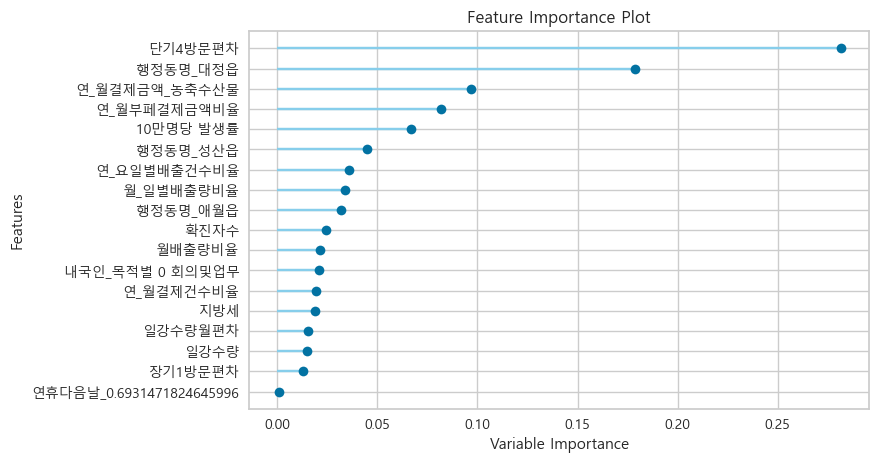

In [87]:
# 피쳐 중요도 확인
plot_model(final_01, 'feature_all' )

In [101]:
# q-q-plot
plot_model(final_03,"residuals_interactive")

    'data': [{'hovertemplate': 'Split=train<br>Predictions…

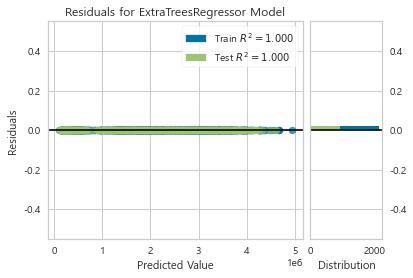

In [68]:
# 피쳐 중요도 확인
plot_model(final_01,"residuals" )
